# Logistic regression

Libraries:
- Data management:
    - [numpy](https://numpy.org/)
    - [pandas](https://pandas.pydata.org/)
    - [scipy](https://scipy.org/) 
- Modelling and scoring:
    - [scikit-learn](https://scikit-learn.org)
- Plotting:
    - [seaborn](https://seaborn.pydata.org/)
    - [matplotlib](https://matplotlib.org/)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from utils import evaluate_classification_metrics

Here I import the `creditcard.csv` dataset, obtained from [Kaggle - Credit Card Fraud Detection](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud). The dataset contains 284,807 transactions, of which 492 are fraudulent. The goal is to predict whether a transaction is fraudulent or not based on the features provided.
I remove the `Time` column, as it is not relevant for the model. I also remove the `Class` column from the features, as it is the target variable. I then split the data into training and testing sets, with 80% of the data used for training and 20% for testing.

In [3]:
df = pd.read_csv("creditcard.csv", sep = ",")

# TODO: Separate the X and y values, tip use the .iloc method to slice the dataframe
X = df.iloc[:, 1:-1].values
# Get the last column as the target
y = df.iloc[:, -1].values

# Convert the pandas dataframes into np.arrays so that we can use all the previous codes we defined
# Warning: Watch out for the dimensions!!
X = np.array(X)
y = np.array(y)


Code to divide the dataset

In [4]:
def train_test_split(X, y, test_size=0.2, stratify=y, random_state=42):
    """
    Splits arrays or matrices into random train and test subsets. This function demonstrates how to 
    divide a dataset into training and testing sets, optionally stratifying the samples and ensuring 
    reproducibility with a random state.

    Parameters:
    - X (np.ndarray): Input features matrix, where rows represent samples and columns represent features.
    - y (np.ndarray): Target labels array, aligned with the samples in X.
    - test_size (float or int): Determines the size of the test set. If float, it represents a proportion 
                                of the dataset; if int, it specifies the number of samples.
    - stratify (np.ndarray): If provided, the function will ensure the class proportions in train and test 
                             sets mirror those of the provided array, typically the target labels array.
    - random_state (int): Seed for the random number generator to ensure reproducible splits.

    Returns:
    - X_train, X_test, y_train, y_test: Arrays containing the split of features and labels into training and 
                                        test sets.
    """
    
    # Set the seed for reproducibility
    if random_state:
        np.random.seed(random_state)

    # Determine the number of samples to allocate to the test set
    n_samples = X.shape[0]
    if isinstance(test_size, float):
        n_test = int(n_samples * test_size)
    else:
        n_test = test_size
    n_train = n_samples - n_test

    # Create an array of indices and shuffle if not stratifying
    indices = np.arange(n_samples)
    if stratify is None:
        np.random.shuffle(indices)
    else:
        # For stratified splitting, determine the distribution of classes
        unique_classes, y_indices = np.unique(stratify, return_inverse=True)
        class_counts = np.bincount(y_indices)
        test_counts = np.round(class_counts * test_size).astype(int)

        # Allocate indices to train and test sets preserving class distribution
        train_indices, test_indices = [], []
        for class_index in range(len(unique_classes)):
            class_indices = indices[y_indices == class_index]
            np.random.shuffle(class_indices)
            boundary = test_counts[class_index]
            test_indices.extend(class_indices[:boundary])
            train_indices.extend(class_indices[boundary:])

        # Concatenate indices to form the final split
        indices = train_indices + test_indices

    # Use the indices to partition the dataset
    X_train = X[indices[:n_train]]
    X_test = X[indices[n_train:]]
    y_train = y[indices[:n_train]]
    y_test = y[indices[n_train:]]

    return X_train, X_test, y_train, y_test


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Training the logistic regression model

Now, it comes the turn to train the logistic regression.

In [6]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(class_weight="balanced", random_state=42, max_iter=10000, solver="liblinear")
lr.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=10000, random_state=42,
                   solver='liblinear')

## Fit assessment

In order to see how well the model fits the data, functions from previous labs will be used. In particular, the function `classification_report` present in `utils.py`. It is strongly encouraged to check out the functions present in that file, as you will see that they represent (our version of) certain functions that may look familiar (with some of the extra exercises). 



{'Confusion Matrix': [np.int64(55536), np.int64(1327), np.int64(10), np.int64(88)], 'Accuracy': np.float64(0.9765277997226173), 'Precision': np.float64(0.06219081272084806), 'Recall': np.float64(0.8979591836734694), 'Specificity': np.float64(0.9766632080614811), 'F1 Score': np.float64(0.1163251817580965)}
Weights: [[ 0.61212416  0.51141827  0.42040724  0.82337234  0.6778324  -0.50362349
  -0.46491551 -0.42490763 -0.20984517 -0.64150204  0.46301631 -1.03006902
  -0.23902236 -1.39406253 -0.11282873 -0.74952298 -0.81486077 -0.2628781
   0.28750776 -0.75539248 -0.16963805  0.5652506   0.3217377  -0.30517931
   0.28213669 -0.67307248  0.17866376  0.78687149  0.00795817]]
Bias: [-4.20966288]


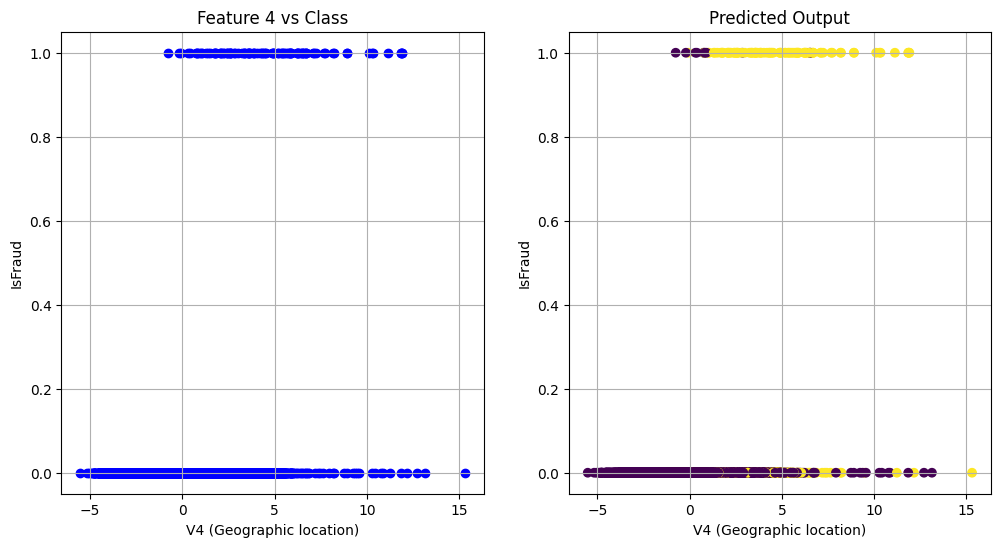

In [7]:
print(evaluate_classification_metrics(y_test, lr.predict(X_test), 1))

# Print weights and bias of the logistic regression model lr
print("Weights:", lr.coef_)
print("Bias:", lr.intercept_)
# Print weights and bias of the logistic regression model LogReg
#print("Weights:", LogReg.weights)
#print("Bias:", LogReg.bias)

# Graph the 4th feature against the class
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(X_test[:, 3], y_test, c='blue', marker='o')
plt.title('Feature 4 vs Class')
plt.xlabel('V4 (Geographic location)')
plt.ylabel('IsFraud')
plt.grid()

y_test_prob = lr.predict_proba(X_test)[:, 1]

# Imprimir en verde los bien clasificados y en rojo los mal clasificados
plt.subplot(1, 2, 2)
plt.scatter(X_test[:, 3], y_test, c=(y_test_prob > 0.5).astype(int), marker='o')
plt.title('Predicted Output')
plt.xlabel('V4 (Geographic location)')
plt.ylabel('IsFraud')
plt.grid()
plt.show()


### Visual analysis

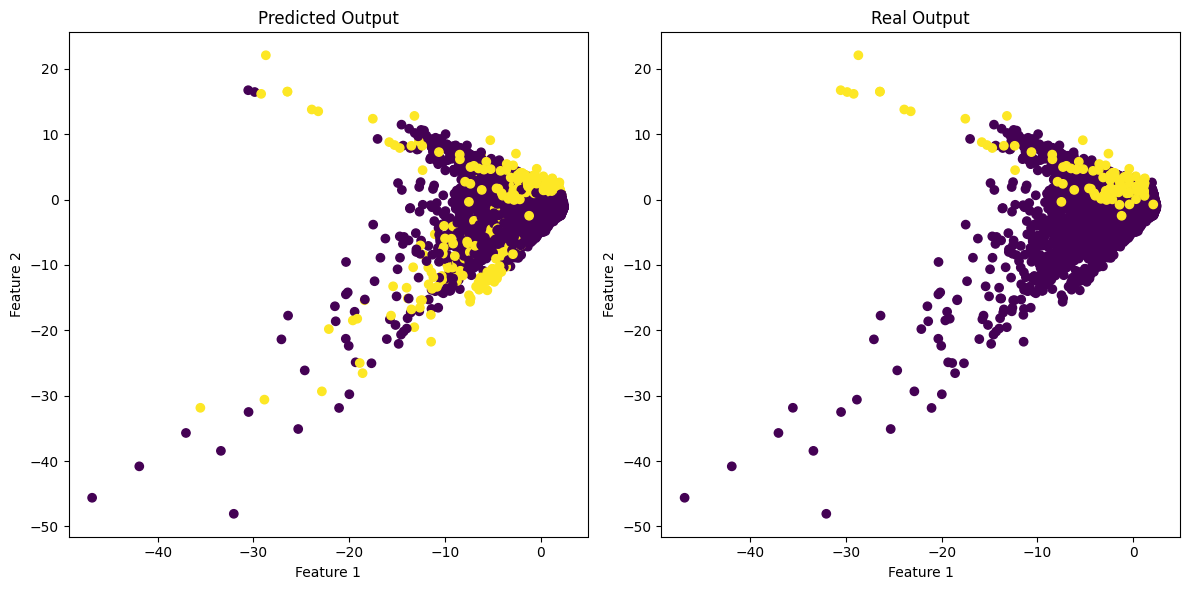

In [8]:
# Plot the first 2 columns of X_test with the predicted output
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(X_test[:, 0], X_test[:, 1], c=(y_test_prob > 0.5).astype(int), cmap='viridis', marker='o')
plt.title('Predicted Output')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

# Plot the first 2 columns of X_test with the real output
plt.subplot(1, 2, 2)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap='viridis', marker='o')
plt.title('Real Output')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

plt.tight_layout()
plt.show()

In [9]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

pca_logreg = Pipeline([
    ('pca', PCA(n_components=10)),  # Reduce to 10 features
    ('scaler', StandardScaler()),  # Normalize features
    ('logreg', LogisticRegression(class_weight="balanced", random_state=42, max_iter=500, solver="liblinear", penalty="l2"))
])

pca_logreg.fit(X_train, y_train)
evaluate_classification_metrics(y_test, pca_logreg.predict(X_test), 1)
#from sklearn.metrics import roc_auc_score
#from sklearn.metrics import roc_curve
#import matplotlib.pyplot as plt
#import seaborn as sns """

{'Confusion Matrix': [np.int64(54933),
  np.int64(1930),
  np.int64(9),
  np.int64(89)],
 'Accuracy': np.float64(0.9659591650427486),
 'Precision': np.float64(0.04408122833085686),
 'Recall': np.float64(0.9081632653061225),
 'Specificity': np.float64(0.9660587728399839),
 'F1 Score': np.float64(0.08408124704770903)}

Ready predictions


C:\Users\EMINE\AppData\Local\Temp\ipykernel_1684\1978400146.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + listclasses, rotation=90)
C:\Users\EMINE\AppData\Local\Temp\ipykernel_1684\1978400146.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + listclasses)


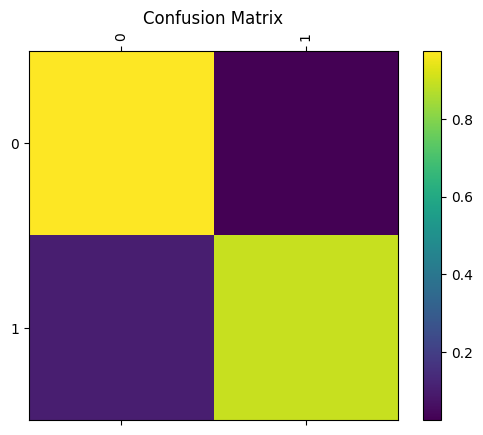

[[0.97666321 0.02333679]
 [0.10204082 0.89795918]]


In [10]:
# CONFUSION MATRIX

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

listclasses = ['0', '1']
numclasses = 2

confusion = np.zeros((numclasses, numclasses))
predictions = lr.predict(X_test)
print("Ready predictions")
for i in range(len(y_test)):
    confusion[int(y_test[i]), int(predictions[i])] += 1

# Normalize by dividing every row by its sum
for i in range(numclasses):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion, cmap='viridis')
plt.title('Confusion Matrix')
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + listclasses, rotation=90)
ax.set_yticklabels([''] + listclasses)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()
print (confusion)